# IN3063 Group 2 Coursework Task 1

# Table of Contents

1. [Dataset Selection and description](#a-dataset-selection-and-description)
2. [Implement sigmoid and ReLU layers](#b-implement-sigmoid-and-relu-layers)
3. [Implement dropout](#d-implement-dropout)
4. [Implement a fully parameterizable neural network class](#e-implement-a-fully-parametrizable-neural-network-class)
5. [Implement optimizer](#f-implement-optimizer)
6. [Evaluate different neural network architectures/parameters present and discuss your results](#g-evaluate-different-neural-network-architecturesparameters-present-and-discuss-your-results)
7. [Code quality and report and presentation](#h-code-quality-and-report-presentation)

## a) Dataset selection and description

Label: 5


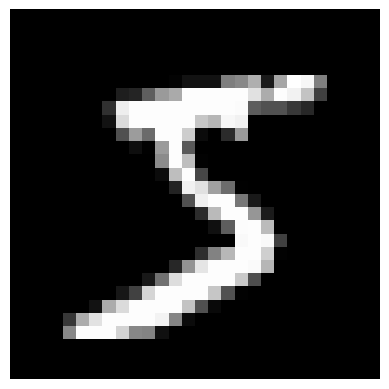

In [234]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())

image, label = mnist_dataset[0]
print("Label:" , label)

plt.imshow(image.squeeze(), cmap="gray")
plt.axis("off") 
plt.show()

## b) Implement sigmoid and ReLU layers

In [235]:
import numpy as np

class SigmoidLayer:
    def __init__(self):
        pass
    
    def forward_pass(self, x):
        self.activation_output = 1 / (1 + np.exp(-x))
        return self.activation_output
    
    def backward_pass(self, activation):
        return (1 - activation) * activation
    

class ReLULayer:
    def __init__(self):
        self.output = None

    def forward_pass(self, x):
        self.output = np.maximum(0, x) #relu is like _/ so max of zero and x 
        return self.output

    def backward_pass(self, upstream_gradient):
        return upstream_gradient * np.where(self.output > 0, 1, 0)

## c) Implement softmax layer

The goal of the softmax layer is to convert raw scores (logits) from the neural network into probabilites that sum to 1.

Here is the softmax formula: $ f(z)_i = \frac{(e^z)_i}{\Sigma_j^K(e^z)_j} $

In [ ]:
import numpy as np
    
class SoftmaxLayer:
    def __init__(self):
        self.output = None
    
    def forward_pass(self, inputs):
        #make sure the dimensions are correct shape
        if inputs.ndim == 1:
            inputs = inputs.reshape(-1, 1)
        exp_values = np.exp(inputs - np.max(inputs, axis=0, keepdims=True)) #subtract max for stability
        #normalise
        probabilities = exp_values / np.sum(exp_values, axis=0, keepdims=True)
        
        self.output = probabilities
        return self.output
    
    def backward_pass(self, activation):
        #cross entropy loss
        return activation

## d) Implement dropout

The goal of the dropout layer is to improve the model's generalization and reduce overfitting by randomly temporarily disabling a fraction of the neurons during training, to prevent the model over-relying on specific neurons

In [237]:
import numpy as np

class DropoutLayer:
    def __init__(self, rate):
        self.rate = rate
        self.mask = None

    def forward_pass(self, inputs, training=True):
        if training:
            self.mask = (np.random.rand(*inputs.shape) > self.rate) / (1 - self.rate)
            return inputs * self.mask
        else:
            return inputs
    
    def backward_pass(self, dvalues):
        return dvalues * self.mask

## e) Implement a fully parametrizable neural network class

Feedforward neural network
You should implement a fully-connected NN class where with number of hidden
layers, units, activation functions can be changed. In addition, you can add dropout or
regularizer (L1 or L2). 


Report the parameters used (update rule, learning rate, decay,
epochs, batch size) and include the plots in your report.

In [ ]:
import numpy as np
from scipy.stats import truncnorm

class NeuraNetwork:
    
     def __init__(self, in_nodes, out_nodes, hidden_layers, hidden_activation, output_activation, dropoutRate=0.0, learning_rate=0.001, regularization=None, lambda_=0.01, epochs=100, optimizer='bgd'):
        # Intialises the neural network 
        #Parameters
        # inNodes: number of input nodes
        # outNodes: number of output nodes
        # hidden_layers: list of number of neurons in each hidden layer. eg [128, 64, 32]
        # hidden_activation: activation function (uses the forward_pass and backward_pass methods) for hidden layers
        # output_activation: activation function for output layer 
        # dropoutRate: dropout rate to reduce overfitting
        # learning_rate: learning rate for training
        # regularization: type of regularization l1 or l2
        # lambda_: regularization strength
        # epochs : the number of epochs that will run over the set
        # optimizer : the selected optimizer out of bdg, sgd, minibgd, momentum
    
        self.in_nodes = in_nodes
        self.out_nodes = out_nodes
        self.hidden_layers = hidden_layers
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.dropoutRate = dropoutRate
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.lambda_ = lambda_
        self.epochs = epochs
        self.optimizer = optimizer
        self.create_weight_matrices()
        self.dropout = DropoutLayer(self.dropoutRate)

     def truncated_normal(self, mean=0, sd=1, low=0, upp=10):
        return truncnorm(
            (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
        #Truncated distribution with a specified mean, standard diviation, and bounds

     def create_weight_matrices(self):
        """method to initialize the weight matrices of the neural network"""
        self.weights = []
        self.biases = []

        #init input to first hiddn layer - make it random so its not all zeroes
        rad = 1 / np.sqrt(self.in_nodes) #type of xavier init - to prevent activations and gradients from growing in a exponential way between layers
        X = self.truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights.append(X.rvs((self.hidden_layers[0], self.in_nodes))) #initial dimensions is num of neurons in first hidden layer by amount of features
        self.biases.append(np.zeros((self.hidden_layers[0], 1))) #inital bias col vector 

        #init hidden layer to next hidden layer for all hidden layers
        for i in range(1, len(self.hidden_layers)):
            rad = 1 / np.sqrt(self.hidden_layers[i-1])
            X = self.truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
            self.weights.append(X.rvs((self.hidden_layers[i], self.hidden_layers[i-1])))
            self.biases.append(np.zeros((self.hidden_layers[i], 1)))

        #init last layer to output layer
        rad = 1 / np.sqrt(self.hidden_layers[-1])
        X = self.truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights.append(X.rvs((self.out_nodes, self.hidden_layers[-1])))
        self.biases.append(np.zeros((self.out_nodes, 1)))

     def apply_regularization(self, weights):
        """applies L1 or L2 regularization."""
        if self.regularization == 'L1':
            return self.lambda_ * np.sign(weights)
        elif self.regularization == 'L2':
            return self.lambda_ * weights
        return 0

     def forward_pass(self, input_vector, training=True):
        """perform a forward pass, each layer has its own weights and bias matrices as init above"""
        activations = [input_vector] #init the activations list to be the input vector 
        for i in range(len(self.weights) -1 ): #for each layer in the nn up to output layer
            #calculate the z value of the neuron which is the dot product of This Layer's weights and the activations of the previous layer added with bias col vector [Z = W(L) * a(L-1) + b(L)]
            z = np.dot(self.weights[i], activations[-1]) + self.biases[i] 
            a = self.hidden_activation.forward_pass(z) #calc the activation value with forward_pass method of the activation func sigmoid or ReLU or softMax
            if training and self.dropoutRate > 0:
                a = self.dropout.forward_pass(a, training) #apply dropout mask if training
            activations.append(a) #update the list of activations, the final nn output is activations[-1] 
        
        #output layer activations
        z_final = np.dot(self.weights[-1], activations[-1]) + self.biases[-1]
        a_final = self.output_activation.forward_pass(z_final)
        activations.append(a_final)

        return activations
    

     def backpropagation(self, activations, target_vector):
        """perform backward pass to compute gradients"""
        error = [target_vector - activations[-1]] #error for each layer 
        gradients_w = []
        gradients_b = []

        #starting from the final layer back to the first layer 
        for i in reversed(range(len(self.weights))):
            #ok so derivative of output error with respect to weight dL/dW(L) = (a(L) - y) * a(L)(1-a(L)) * a(L-1) (in the case of sigmoid)
            #error[-1] contains (a(L) - y)
            #so we multiply it by the derivative of the activation function a(L)(1-a(L)) for sigmoid 
            #so delta = dL/dZ = dL/dA * dA/dZ. 
            delta = error[-1] * self.hidden_activation.backward_pass(activations[i+1])
            #to get the gradient dL/dw(L) we need to multiply dL/dZ (delta) by dZ(L)/dW(L). Which is same as delta * a(L-1) as well as any regularization that prevents overfitting
            gradients_w.append(np.dot(delta, activations[i].T) + self.apply_regularization(self.weights[i]))
            gradients_b.append(delta) # dL/db(L) = dL/∂Z(L) * dZ(L)/db(L) = delta * 1 = delta
            if i > 0:
                error.append(np.dot(self.weights[i].T, delta)) #propogate the error backward to get each neurons contribution to error 

        gradients_w.reverse()
        gradients_b.reverse()
        return gradients_w, gradients_b

     def train(self, input_data, target_data):
        """
        train with basic gradient descent over given number of epoches
        """
        input_data = np.array(input_data)
        target_data = np.array(target_data)
        
        for epoch in range(self.epochs):

            total_loss = 0
            correct_predictions = 0

            for sample in range(len(input_data)): #for each sample we do a full forward pass and backward pass and update of the weights
                
                #make sure theyre in the correct dimensions
                input_vector = np.expand_dims(input_data[sample], axis=1)
                target_vector = np.expand_dims(target_data[sample], axis=1)
                
                activations = self.forward_pass(input_vector, training=True)

                #calc cross-entropy loss
                epsilon = 1e-15  #prevent log(0)
                output = np.clip(activations[-1], epsilon, 1 - epsilon)
                loss = -np.sum(target_vector * np.log(output))
                total_loss += loss
                
                #track the accuracy
                predicted = np.argmax(activations[-1])
                true_label = np.argmax(target_vector)
                if predicted == true_label:
                    correct_predictions += 1

                gradients_w, gradients_b = self.backpropagation(activations, target_vector)

                #update each layers weights 
                for i in range(len(self.weights)):
                    self.weights[i] += self.learning_rate * gradients_w[i]
                    self.biases[i] += self.learning_rate * np.sum(gradients_b[i], axis=1, keepdims=True)

            print(f"Epoch {epoch + 1}/{self.epochs} completed.")
            
        #print current epoch stats
        avg_loss = total_loss / len(input_data)
        accuracy = correct_predictions / len(input_data) * 100
        print(f"Epoch {epoch + 1}/{self.epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.2f}%")
            
     def run(self, input_vector):
        """
        prediction method, does a forward pass through the network on the input vector and returns the final activation vector
        """
        input_vector = np.array(input_vector, ndmin=2).T 
        activations = [input_vector]
        
        #forward pass through the network (no dropout during testing/prediction)
        for i in range(len(self.weights)):
            z = np.dot(self.weights[i], activations[-1]) + self.biases[i]
            a = self.hidden_activation.forward_pass(z)
            activations.append(a)
        
        return activations[-1]

## Initial Tests

This test was performed before implementing optimisers as seperate class and so it was just done with vanilla batch gradient descent

Epoch 1/20 completed.
Epoch 2/20 completed.
Epoch 3/20 completed.
Epoch 4/20 completed.
Epoch 5/20 completed.
Epoch 6/20 completed.
Epoch 7/20 completed.
Epoch 8/20 completed.
Epoch 9/20 completed.
Epoch 10/20 completed.
Epoch 11/20 completed.
Epoch 12/20 completed.
Epoch 13/20 completed.
Epoch 14/20 completed.
Epoch 15/20 completed.
Epoch 16/20 completed.
Epoch 17/20 completed.
Epoch 18/20 completed.
Epoch 19/20 completed.
Epoch 20/20 completed.
Epoch 20/20 - Loss: 1.8393 - Accuracy: 34.13%
Predicted class: 7

Probability distribution:
Class 0: 0.9983
Class 1: 0.9932
Class 2: 0.9989
Class 3: 0.9991
Class 4: 0.9994
Class 5: 0.9990
Class 6: 0.9991
Class 7: 0.9996
Class 8: 0.9990
Class 9: 0.9995

True label: 7


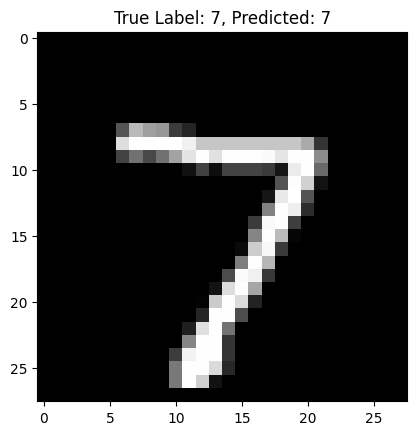

'\n# Evaluate on binary classification test set\ncorrect = 0\nfor i in range(len(binary_test_images)):\n    output = nn.run(binary_test_images[i])\n    predicted_class = 1 if output >= 0.5 else 0\n    if predicted_class == binary_test_labels[i]:\n        correct += 1\n\naccuracy = correct / len(binary_test_images)\nprint(f"Accuracy on binary classification test set: {accuracy * 100:.2f}%")\n'

In [239]:

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

train_images = mnist_train.data.numpy().reshape(-1, 28*28) / 255.0  #[0, 1]
train_labels = mnist_train.targets.numpy()

test_images = mnist_test.data.numpy().reshape(-1, 28*28) / 255.0
test_labels = mnist_test.targets.numpy()

def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

train_labels_one_hot = one_hot_encode(train_labels)
test_labels_one_hot = one_hot_encode(test_labels)

sigmoid = SigmoidLayer()
softmax = SoftmaxLayer()

nn = NeuraNetwork(
    in_nodes=784,             #28x28 pixels flattened
    out_nodes=10,             #10 digits
    hidden_layers=[128, 64],  #two hidden layers
    hidden_activation=sigmoid,    #sigmoid for hidden layers
    output_activation=softmax,    #softmax for output layer
    dropoutRate=0.2,
    learning_rate=0.001,
    epochs=20
)

nn.train(train_images, train_labels_one_hot)


test_sample = test_images[0]
output = nn.run(test_sample)
probabilities = output.flatten()  #convert to normal array
predicted_class = np.argmax(probabilities)

print("Predicted class:", predicted_class)
print("\nProbability distribution:")
for i, prob in enumerate(probabilities):
    print(f"Class {i}: {prob:.4f}")
print(f"\nTrue label: {test_labels[0]}")

import matplotlib.pyplot as plt
plt.imshow(test_images[0].reshape(28, 28), cmap='gray')
plt.title(f"True Label: {test_labels[0]}, Predicted: {predicted_class}")
plt.show()


Epoch 1/20 completed.
Epoch 2/20 completed.
Epoch 3/20 completed.
Epoch 4/20 completed.
Epoch 5/20 completed.
Epoch 6/20 completed.
Epoch 7/20 completed.
Epoch 8/20 completed.
Epoch 9/20 completed.
Epoch 10/20 completed.
Epoch 11/20 completed.
Epoch 12/20 completed.
Epoch 13/20 completed.
Epoch 14/20 completed.
Epoch 15/20 completed.
Epoch 16/20 completed.
Epoch 17/20 completed.
Epoch 18/20 completed.
Epoch 19/20 completed.
Epoch 20/20 completed.
Epoch 20/20 - Loss: 2.3012 - Accuracy: 11.24%
Predicted class: 1

Probability distribution:
Class 0: 0.0988
Class 1: 0.1119
Class 2: 0.0995
Class 3: 0.1022
Class 4: 0.0973
Class 5: 0.0905
Class 6: 0.0985
Class 7: 0.1046
Class 8: 0.0978
Class 9: 0.0989

True label: 7


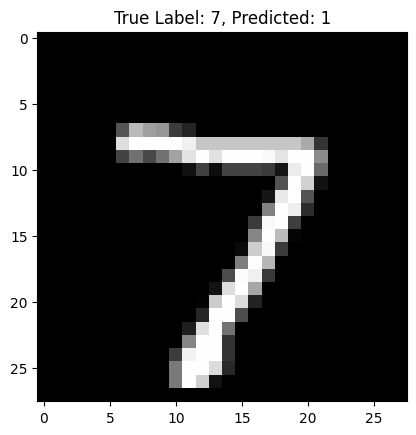

In [240]:
nn2 = NeuraNetwork(
    in_nodes=784,             #28x28 pixels flattened
    out_nodes=10,             #10 digits
    hidden_layers=[128, 64],  #Two hidden layers
    hidden_activation=softmax,    #softmax for hidden layers
    output_activation=softmax,    #softmax for output layer
    dropoutRate=0.2,
    learning_rate=0.001,
    epochs=20
)

nn2.train(train_images, train_labels_one_hot)


test_sample = test_images[0]
output = nn2.run(test_sample)
probabilities = output.flatten()  
predicted_class = np.argmax(probabilities)

print("Predicted class:", predicted_class)
print("\nProbability distribution:")
for i, prob in enumerate(probabilities):
    print(f"Class {i}: {prob:.4f}")
print(f"\nTrue label: {test_labels[0]}")


import matplotlib.pyplot as plt
plt.imshow(test_images[0].reshape(28, 28), cmap='gray')
plt.title(f"True Label: {test_labels[0]}, Predicted: {predicted_class}")
plt.show()

## f) Implement optimizer

I will be implementing stochastic gradient descent, mini batch descent and momentum batch descent in addition to the default batch descent already present, this will require changing the train() method of the nn class to make it fully parameterizable but I will make the classes for it here based on an interface class

In [ ]:
class Optimizer: #this is like an interface class so i will use the notimplemented error exception because update needs to be done by all the optimisers
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        
    def initialize(self, weights, biases): #only needs to be done by momentum for the velocities
        pass
    
    def update(self, weights, biases, weight_gradients, bias_gradients):
        #update botth the weights and the bias vectors that we get from backpropagation
        raise NotImplementedError

    def should_update_per_sample(self):
        #basically a boolean to see if the weights and biases should be updated every sample - for sgd
        return False

class Batch(Optimizer):
    #basic full batch gradient descent just taken from the original train method
    def update(self, weights, biases, weight_gradients, bias_gradients):
        updated_weights = []
        updated_biases = []
        
        #use zip its the same effect as doing for i in range(len(self.weights)) and referencing the ith elem but is cleaner imo
        for w, b, w_grad, b_grad in zip(weights, biases, weight_gradients, bias_gradients):
            updated_w = w - self.learning_rate * w_grad
            updated_b = b - self.learning_rate * np.sum(b_grad, axis=1, keepdims=True)
            
            updated_weights.append(updated_w)
            updated_biases.append(updated_b)
            
        return updated_weights, updated_biases

class SGD(Optimizer):
    def should_update_per_sample(self):
        #sgd updates the weights after each sample becuase it can lead to quicker convergence
        return True
    
    def update(self, weights, biases, weight_gradients, bias_gradients):
        #updates weights and biases using SGD - we update immediately using the gradients from a single sample, so no need to average or accumulate gradients
        
        updated_weights = []
        updated_biases = []
        
        for w, b, w_grad, b_grad in zip(weights, biases, weight_gradients, bias_gradients):
            #direct update
            updated_w = w - self.learning_rate * w_grad
            updated_b = b - self.learning_rate * b_grad
            
            updated_weights.append(updated_w)
            updated_biases.append(updated_b)
            
        return updated_weights, updated_biases

class Momentum(Optimizer):

    def __init__(self, learning_rate, momentum=0.9):
        super().__init__(learning_rate)
        self.momentum = momentum
        self.velocity_w = None
        self.velocity_b = None
        
    def initialize(self, weights, biases):
        #initial velocities are zero 
        self.velocity_w = [np.zeros_like(w) for w in weights]
        self.velocity_b = [np.zeros_like(b) for b in biases]
    
    def update(self, weights, biases, weight_gradients, bias_gradients):
        updated_weights = []
        updated_biases = []
        
        for i, (w, b, w_grad, b_grad) in enumerate(zip(weights, biases, weight_gradients, bias_gradients)):
            #update the velocity each step
            self.velocity_w[i] = self.momentum * self.velocity_w[i] - self.learning_rate * w_grad
            self.velocity_b[i] = self.momentum * self.velocity_b[i] - self.learning_rate * np.sum(b_grad, axis=1, keepdims=True)
            
            updated_w = w + self.velocity_w[i]
            updated_b = b + self.velocity_b[i]
            
            updated_weights.append(updated_w)
            updated_biases.append(updated_b)
            
        return updated_weights, updated_biases #will become the nn class new self.weights and self.biases

class MiniBatch(Optimizer):
    def __init__(self, learning_rate, batch_size=32):
        super().__init__(learning_rate)
        self.batch_size = batch_size #now we can deal with smaller batches
        
    def get_batches(self, input_data, target_data):
        #create the batches 
        n_samples = len(input_data)
        indices = np.random.permutation(n_samples) #init the random batch indexes to know where is the start and end 
        
        batch_starts = range(0, n_samples, self.batch_size)
        
        batches = []
        for start in batch_starts:
            end = min(start + self.batch_size, n_samples)
            batch_indices = indices[start:end]
            
            input_batch = input_data[batch_indices]
            target_batch = target_data[batch_indices]
            
            batches.append((input_batch, target_batch))
            
        return batches
    
    def update(self, weights, biases, weight_gradients, bias_gradients):
        updated_weights = []
        updated_biases = []
        
        for w, b, w_grad, b_grad in zip(weights, biases, weight_gradients, bias_gradients):
            #average of EACH BATCH
            w_grad_mean = np.mean(w_grad, axis=0) if isinstance(w_grad, list) else w_grad
            b_grad_mean = np.mean(b_grad, axis=1, keepdims=True) if isinstance(b_grad, list) else b_grad
            
            #same update as normal batch descent 
            updated_w = w - self.learning_rate * w_grad_mean
            updated_b = b - self.learning_rate * b_grad_mean
            
            updated_weights.append(updated_w)
            updated_biases.append(updated_b)
            
        return updated_weights, updated_biases

## g) Evaluate different neural network architectures/parameters, present and discuss your results. 